In [132]:
import xarray as xr

era5 = xr.open_dataset("/Users/james/Downloads/ERA5_2m_specific_humidity_1996.nc")
f = 'huss'

times = era5['time']
latitudes = era5['latitude']
longitudes = era5['longitude']

# extend the longitude coordinate by 1
datasets = []
datasets.append(longitudes)
# add 0.25 degrees to the final longitude value because the resolution of the ERA5 is 0.25 degrees
datasets.append(longitudes[-1] + 0.25)
longitudes = xr.concat(datasets, dim='longitude')

era5_ext = xr.Dataset({
    f : xr.DataArray(
                data   = np.zeros((len(range(0,era5.dims['time'])), len(range(0,era5.dims['latitude'])), len(range(0,era5.dims['longitude']+1)))),   # enter data here
                dims   = ['time', 'latitude', 'longitude'],
                coords = {'time': times, 'latitude' : latitudes, 'longitude' : longitudes},
                attrs  = {
                    'units'     : era5.huss.attrs['units']
                    }
                )})

era5_ext[f].values[:,:,0:len(era5['longitude'])] = era5[f].values
era5_ext[f].values[:,:,len(era5['longitude']):len(era5['longitude']) + 1] = era5[f][:,:,0:1].values


In [133]:
era5_ext

<xarray.Dataset>
Dimensions:    (latitude: 259, longitude: 320, time: 8786)
Coordinates:
  * time       (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
  * latitude   (latitude) float32 0.25 0.5 0.75 1.0 ... 64.0 64.25 64.5 64.75
  * longitude  (longitude) float64 260.2 260.5 260.8 261.0 ... 339.5 339.8 340.0
Data variables:
    huss       (time, latitude, longitude) float64 0.01339 0.01337 ... 6.594e-05

In [124]:
longitudes[-1] + 0.25

<xarray.DataArray 'longitude' ()>
array(340.)
Coordinates:
    longitude  float32 339.8
    height     float64 2.0

In [147]:
((80.93*21) + (84.61*21) + (76.4*21) + (70*10) + (68.1*27))/100

76.1944

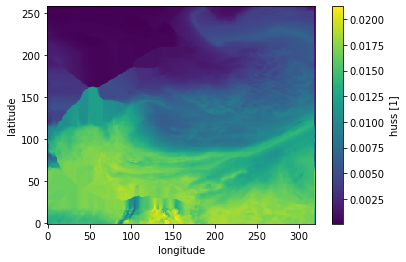

In [112]:
era5_ext[f][0].plot()

In [ ]:
# slice down the data
import xarray as xr
import os
import cftime
import numpy as np
from glob import glob
import os

# Functions for humidity borrowed and adapted from MetPy.calc: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html
def mixing_ratio(partial_press, total_press, molecular_weight_ratio=0.622):
    return (molecular_weight_ratio * partial_press
                / (total_press - partial_press))


def specific_humidity_from_mixing_ratio(mr):
    return mr / (1 + mr)


def saturation_vapor_pressure(temperature):
    sat_pressure_0c = 6.112e2 # Pa
    return sat_pressure_0c * np.exp(17.67 * (temperature - 273.15) # K -> C
                                        / (temperature - 29.65))   # K -> C

def saturation_mixing_ratio(total_press, temperature):
    return mixing_ratio(saturation_vapor_pressure(temperature), total_press)



era5_dict = {'ERA5_sea_ice_cover':'siconc',
            'ERA5_10m_u_component_of_wind':'u10',
            'ERA5_sea_surface_temperature':'sst',
            'ERA5_10m_v_component_of_wind':'v10',
            'ERA5_2m_temperature':'t2m',
            'ERA5_surface_solar_radiation_downwards':'ssrd',
            'ERA5_surface_thermal_radiation_downwards':'strd',
            'ERA5_total_rain_rate':'trr',
            'ERA5_mean_sea_level_pressure':'msl',
            'ERA5_2m_specific_humidity':'huss'}

years=range(1996,1998)
#subset
era5dir = "/Volumes/P5/ERA5/"
subdir2="/Volumes/P8/workdir/james/ERA5/nwa25/subset/"
subdir="/home/james/era5/"
for f in era5_dict.keys():
    print(f)
    for y in years:
        print(y)
        if f=='ERA5_total_rain_rate':
            crr = xr.open_dataset(str(era5dir + 'ERA5_convective_rain_rate_' + str(y) + '.nc')).sel(latitude=slice(65,0), longitude=slice(260,340))
            lsrr = xr.open_dataset(str(era5dir + 'ERA5_large_scale_rain_rate_' + str(y) + '.nc')).sel(latitude=slice(65,0), longitude=slice(260,340))
            trr = crr.drop('crr')
            trr['trr'] = crr['crr'] + lsrr['lsrr']
            trr['trr'].attrs = {'units': 'kg m-2 s-1','long_name': 'Total Rainfall Rate'}
            trr.trr.encoding = {k: v for k, v in crr.crr.encoding.items() if k in {'_FillValue', 'missing_value', 'dtype'}}
            #trr.trr.encoding.update({'add_offset': None, 'scale_factor': None})
            trr.to_netcdf(str(subdir + f + '_' + str(y) + ".nc"), mode='w', format='NETCDF4_CLASSIC')
            crr.close()
            lsrr.close()
            trr.close()
        if f=='ERA5_2m_specific_humidity':
            pair = xr.open_dataset(str(era5dir + 'ERA5_surface_pressure_' + str(y) + '.nc'))['sp'].sel(latitude=slice(65,0), longitude=slice(260,340)) # Pa
            tdew = xr.open_dataset(str(era5dir + 'ERA5_2m_dewpoint_temperature_' + str(y) + '.nc'))['d2m'].sel(latitude=slice(65,0), longitude=slice(260,340)) # K

            smr = saturation_mixing_ratio(pair, tdew)
            sphum = specific_humidity_from_mixing_ratio(smr)

            sphum.name = 'huss'
            sphum = sphum.to_dataset()

            # Remove all _FillValue
            all_vars = list(sphum.data_vars.keys()) + list(sphum.coords.keys())
            encodings = {v: {'_FillValue': None} for v in all_vars}

            # Also fix the time encoding
            encodings['time'].update({'dtype':'float64', 'calendar': 'gregorian', 'units': 'hours since 1900-01-01 00:00:00'})
            
            fout=str(subdir + f + '_' + str(y) + ".nc")
            sphum.to_netcdf(
                fout,
                format='NETCDF4_CLASSIC',
                engine='netcdf4',
                encoding=encodings,
                unlimited_dims=['time']
            )
            sphum.close()
            
        if 'total_rain_rate' not in f and 'specific_humidity' not in f:
            ds=xr.open_dataset(str(era5dir + f + '_' + str(y) + ".nc")).sel(latitude=slice(65,0), longitude=slice(260,340))
            ds.to_netcdf(str(subdir + f + '_' + str(y) + ".nc"),format="NETCDF4_CLASSIC")
            ds.close()